In this notebbok, we prove that LSTM fail into capturing long memory in multivariate time series.

Then, we applied the two complementary tests detailed in the paper *A Statistical Investigation of Long Memory in Language and Music* by Greaves-Tunnell, Alexander and Harchaoui, Zaid.

The two tests consists into checking the GSE statistics of the long memory vector d in the last hidden layer of the trained LSTM.

The difference between the two tests: the first test consists into training the LSTM on a Fractionnaly differenced WN while the second test consists into training the LSTM on a WN

In [24]:
#Google collab setting
import os
import sys
sys.path.append("/content/LSTM-long-memory/Test Kelly")

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from _varfima import sim_VARFIMA, sim_FD
from torch.utils.data import DataLoader, TensorDataset
import optuna
torch.manual_seed(42) #For reproductibility
from d_test import compute_total_memory

# Test 1: Integration of Fractionnaly Differenced WN

##### Generation of a random Fractionally Differenced White Noise

In [4]:
# First let's generate a random long memory paramater vector (d)

np.random.seed(42)
k= 200 #number of time series
d_min, d_max = 0.05, 0.45  # to have a long memory vector parameter (d in ]0,0.5[**p)
d = torch.tensor(np.random.uniform(d_min, d_max, size=k), dtype=torch.float32)

#Then let's generated a fractionnally differenced white noise based on the generated d vector, of length T
T=2**16 #same length as in the paper
FD_seq, _ = sim_FD(T=2**16, k=200, d=d)

### Let's build a LSTM with two layers for multivariate time series prediction

In [5]:
#Let's build the LSTM model for time series prediction

class LSTMPredictor(nn.Module):
    """LSTM for time series prediction"""

    def __init__(self, input_size, hidden_size=64, num_layers=2,
                 dropout=0.2, forecast_horizon=1):
        """
        Args:
            input_size: Number of features (k variables)
            hidden_size: Size of the hidden state
            num_layers: Number of layers in the LSTM
            dropout: Dropout rate between LSTM layers
            forecast_horizon: Number of time steps to predict
        """
        super(LSTMPredictor, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon

        # Couche LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True  # (batch, seq, feature)
        )

        # Couche fully connected pour la prédiction
        self.fc = nn.Linear(hidden_size, input_size * forecast_horizon)

        self.input_size = input_size

    def forward(self, x):
        """
        Args:
            x: (batch, seq_length, input_size)
        Returns:
            predictions: (batch, forecast_horizon, input_size)
        """
        batch_size = x.size(0)

        # LSTM forward
        # lstm_out: (batch, seq_length, hidden_size)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Prendre la dernière sortie temporelle
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Prédiction
        predictions = self.fc(last_output)  # (batch, input_size*forecast_horizon)

        # Reshape pour séparer forecast_horizon et input_size
        predictions = predictions.view(batch_size, self.forecast_horizon,
                                      self.input_size)

        return predictions

k=200

##### Data preparation

In [8]:
FD_seq.shape #we have a non supervised dataset of shape (k,T)

torch.Size([200, 65536])

In [6]:
def unfold_sequence_to_supervised_dataset(data, seq_length, forecast_horizon=1):
    """
    Create a supervised dataset from multivariate time series sequence.
    with a rolling window approach.
    Args:
        data: torch.Tensor of shape (k, T)
        seq_length: length of the input window (size of X)
        forecast_horizon: number of steps to predict (size of y)

    Returns:
        X: (n_samples, seq_length, k)
        y: (n_samples, forecast_horizon, k)
    """
    data = data.T  # (T, k)
    T, k = data.shape

    n_samples = T - seq_length - forecast_horizon + 1

    X = torch.zeros((n_samples, seq_length, k))
    y = torch.zeros((n_samples, forecast_horizon, k))

    for idx in range(n_samples):
        X[idx] = data[idx:idx+seq_length]
        y[idx] = data[idx+seq_length:idx+seq_length+forecast_horizon]

    return X.float(), y.float()

dataset = unfold_sequence_to_supervised_dataset(FD_seq, seq_length=10, forecast_horizon=1)

In [10]:
print(f"Size of X: {dataset[0].shape} \nSize of y: {dataset[1].shape}")

Size of X: torch.Size([65526, 10, 200]) 
Size of y: torch.Size([65526, 1, 200])


In [7]:
#Let's prepare the dataset of training and validation

#tensorisation of the dataset
full_dataset= torch.utils.data.TensorDataset(dataset[0], dataset[1])

# Split train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# Batching
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f" Prepared dataset:")
print(f"  - Train samples: {len(train_dataset)}")
print(f"  - Val samples: {len(val_dataset)}")
print(f"  - Batch size: {batch_size}")


 Prepared dataset:
  - Train samples: 52420
  - Val samples: 13106
  - Batch size: 32


##### Data Training

Entraînement sur cuda
Epoch [5/150] Train Loss: 1.162830 | Val Loss: 1.153153
Epoch [10/150] Train Loss: 1.153051 | Val Loss: 1.146157
Epoch [15/150] Train Loss: 1.148982 | Val Loss: 1.143504
Epoch [20/150] Train Loss: 1.146887 | Val Loss: 1.143401
Epoch [25/150] Train Loss: 1.145320 | Val Loss: 1.142526
Epoch [30/150] Train Loss: 1.127938 | Val Loss: 1.130256
Epoch [35/150] Train Loss: 1.122597 | Val Loss: 1.128206
Epoch [40/150] Train Loss: 1.119926 | Val Loss: 1.126803
Epoch [45/150] Train Loss: 1.118144 | Val Loss: 1.127032
Epoch [50/150] Train Loss: 1.116830 | Val Loss: 1.125742
Epoch [55/150] Train Loss: 1.115946 | Val Loss: 1.125688
Epoch [60/150] Train Loss: 1.115167 | Val Loss: 1.125492
Epoch [65/150] Train Loss: 1.114338 | Val Loss: 1.125607
Epoch [70/150] Train Loss: 1.111388 | Val Loss: 1.124472
Epoch [75/150] Train Loss: 1.111095 | Val Loss: 1.124318
Epoch [80/150] Train Loss: 1.110490 | Val Loss: 1.124219
Epoch [85/150] Train Loss: 1.110466 | Val Loss: 1.124151
Epoch [90/

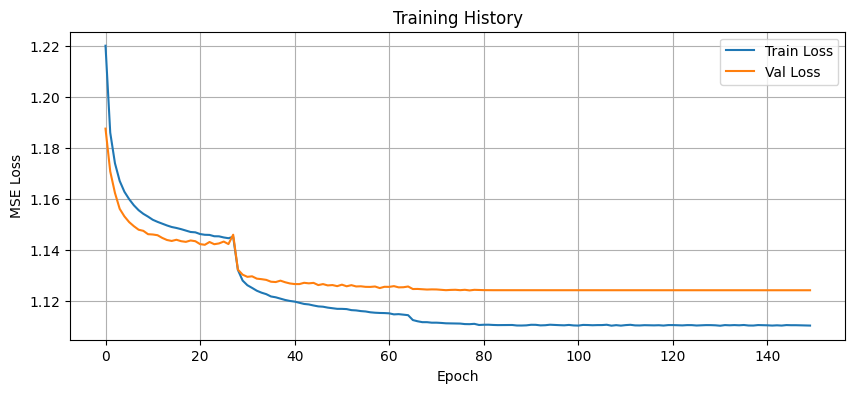

✓ Modèle sauvegardé: lstm_varfima_model.pth


In [17]:
#Let's train the LSTM on the generated data using a ADAM optimizer and MSE loss
#parameters of training:
#for the optimizer: lr=0.01, scheduler (LROnPlateau): patience=5, eps=1e-6
#for the LSTM: 64 hidden size, 2 layers, dropout of 0.2

#Let's load the built LSTM model of two layers adapted to our multivariate time series of size k=200
lstm_model = LSTMPredictor(
    input_size=k,
    hidden_size=64,
    dropout=0.2)

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, eps=1e-6) #automatic learning rate adjustment

num_epochs = 150 #iteration number

# Historique des pertes
train_losses = []
val_losses = []

print(f"Entraînement sur {device}")
print("=" * 50)

for epoch in range(num_epochs):
    # === TRAINING ===
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Affichage
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("=" * 50)
print("✓ Entraînement terminé")

# Visualisation of loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()

# Let's save the trained model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
}, 'lstm_varfima_model.pth')

print("✓ Modèle sauvegardé: lstm_varfima_model.pth")

The validation loss seems to have reached a plateau at around 50 iterations with a loss around 1.12. We can stop our training at 50 iterations.

Let's search for the optimal hyperparameter for the training.
Let's test the training on different loss (MSE, MAE, Huber), optimizer (Adam, SGD, rmsprop) and lr range and let's find the optimal combinaison.

We tried to run a GridSearch on the hyperparameter of the model (hidden_size) and the data loaded (length_seq in the rolling window) but it did not led to significant change in the loss. Considering that we work on a 2 layers LSTM, which can already easily fit our sequence, it's logical

In [ ]:
def train_model(model, optimizer, train_loader, val_loader, epochs=50):
    criterion = nn.MSELoss()
    model = model.to(device)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5
    )

    for epoch in range(epochs):

        # ===== TRAIN =====
        model.train()
        train_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # ===== VALIDATION =====
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Scheduler
        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(
                f"Epoch {epoch+1:03d} | "
                f"Train Loss={avg_train_loss:.6f} | "
                f"Val Loss={val_loss:.6f} | "
                f"LR={current_lr:.6e}"
            )

    return model


#GridSearch with Optuna to find better lr, optimizer
def objective(trial):

    # ===== Hyperparamètres =====
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    loss_name = trial.suggest_categorical("loss_fn", ["MSE", "MAE", "Huber"])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
    #ajouter num_layers ??

    # ===== Dataset rolling window =====
    X, y = unfold_sequence_to_supervised_dataset(
        FD_seq, seq_length=50, forecast_horizon=1
    )

    X = X.detach().clone().float()
    y = y.detach().clone().float()

    # ===== Split train / val =====
    train_size = int(0.8 * len(X))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    # ===== DataLoaders (OBLIGATOIREMENT ici) =====
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )

    # ===== Modèle =====
    input_size = X.shape[-1]

    model = LSTMPredictor(
        input_size=input_size,
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    ).to(device)

    # optimizer
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    if loss_name == "MSE":
        criterion = nn.MSELoss()
    elif loss_name == "MAE":
        criterion = nn.L1Loss()
    elif loss_name == "Huber":
        criterion = nn.SmoothL1Loss()

    # ===== Entraînement =====
    train_model(
        model,
        optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=30
    )

    # ===== Évaluation finale validation =====
    model.eval()
    criterion = nn.MSELoss()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20) #test 20 combinaisons d'hyperparameter
print("Meilleurs paramètres :", study.best_params)
print(f"Meilleure val loss : {study.best_value:.6f}")


[I 2026-01-07 11:47:46,100] A new study created in memory with name: no-name-e384505f-2c10-4e11-8d94-b553a932e19e
/tmp/ipython-input-1365771064.py:68: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)


Epoch 010 | Train Loss=1.142080 | Val Loss=1.211340 | LR=1.017783e-02
Epoch 020 | Train Loss=1.134977 | Val Loss=1.205222 | LR=5.088917e-03
Epoch 030 | Train Loss=1.116067 | Val Loss=1.194519 | LR=5.088917e-03


[I 2026-01-07 11:51:19,108] Trial 0 finished with value: 1.1945194445005278 and parameters: {'optimizer': 'adam', 'loss_fn': 'Huber', 'lr': 0.01017783394492198}. Best is trial 0 with value: 1.1945194445005278.


Epoch 010 | Train Loss=1.099575 | Val Loss=1.139952 | LR=9.078544e-04
Epoch 020 | Train Loss=1.091933 | Val Loss=1.139639 | LR=9.078544e-04
Epoch 030 | Train Loss=1.083909 | Val Loss=1.137776 | LR=4.539272e-04


[I 2026-01-07 11:54:48,782] Trial 1 finished with value: 1.1377756927071547 and parameters: {'optimizer': 'adam', 'loss_fn': 'MAE', 'lr': 0.0009078544002996144}. Best is trial 1 with value: 1.1377756927071547.


Epoch 010 | Train Loss=1.395433 | Val Loss=1.437385 | LR=3.415422e-02
Epoch 020 | Train Loss=1.331867 | Val Loss=1.364153 | LR=8.538554e-03
Epoch 030 | Train Loss=1.320585 | Val Loss=1.355030 | LR=4.269277e-03


[I 2026-01-07 11:58:19,656] Trial 2 finished with value: 1.3550301810590233 and parameters: {'optimizer': 'adam', 'loss_fn': 'MAE', 'lr': 0.06830843164664009}. Best is trial 1 with value: 1.1377756927071547.


Epoch 010 | Train Loss=1.131952 | Val Loss=1.177002 | LR=1.428141e-04
Epoch 020 | Train Loss=1.104869 | Val Loss=1.145317 | LR=1.428141e-04


#### Let's verify the long memory property in the LSTM trained

First, let's extract the last layer of our trained LSTM

In [38]:
#Loading the trained model
model.load_state_dict(torch.load('lstm_varfima_model.pth')["model_state_dict"])
model.to(device)
model.eval()

#initialisation des états cachés (h: hidden state, c: cell state, mémoire interne)
h = torch.zeros(model.num_layers, 1, model.hidden_size).to(device)
c = torch.zeros(model.num_layers, 1, model.hidden_size).to(device)

hidden_states = []
with torch.no_grad():
    for t in range(T):
        input_t = FD_seq[:, t:t+1].T.unsqueeze(0).to(device)  # (1, 1, k)
        lstm_out, (h, c) = model.lstm(input_t, (h, c))
        hidden_states.append(h[-1, 0, :].cpu().numpy()) #last layer

hidden_rep = np.array(hidden_states).T

We're using an already coded function "compute_total_memory" that computes the long memory parameter d, based on a temporal sequence and by using a GSE statistics. Then, this function conducts a test on the long memory on the computed statistics and returns the parameter d estimated and its p-value.

More specificially the function is testing H0: d= 0 vs H0: d>0

The null hypothesis is the existence of long memory since... (add formula inLatex format)


In [39]:
# Test long memory
tot_mem_hidden, std_var_hidden, p_val_hidden = compute_total_memory(
    hidden_rep)

print(f"\nHidden states LSTM:")
print(f"  Mémoire longue totale: {tot_mem_hidden:.4f}")
print(f"  Écart-type: {np.sqrt(std_var_hidden):.4f}")
print(f"  p-value (H0: d=0): {p_val_hidden:.4e}")
print(f"Mémoire longue significative: {'NON' if p_val_hidden < 0.05 else 'OUI'}")


Hidden states LSTM:
  Mémoire longue totale: 0.4342
  Écart-type: 0.0625
  p-value (H0: d=0): 1.8646e-12
Mémoire longue significative: NON


We ran the test on the last layer of our LSTM and the test gave a statistic d= 0.4342 and a p-value significative. We can reject the hypothesis of long memory.

In [ ]:
#once we have the optimal hyperparameters, we can do the test on n=100 different FD_seq generated
#like in the paper
#With around 50 epochs for each test

# Test 2 (complementary) Long memory transformation of White Noise

In [ ]:
#generation of a WN sequence of length T and size k=200
#training of the LSTM model on this WN sequence
#computing the statistics of the learned LSTM
#checking if d=0 (short memory) or d>0 (long memory)
#OK